<a href="https://colab.research.google.com/github/vippatil1604/air_quality_index_forecasting/blob/main/SARIMA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.1.1-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
import csv

In [8]:
aqi_df = spark.read.csv("/content/drive/MyDrive/Project/Data/daily_aqi_by_county_20*.csv", header=True)
aqi_df.show()

+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|State Name|county Name|State Code|County Code|      Date|AQI|Category|Defining Parameter|Defining Site|Number of Sites Reporting|
+----------+-----------+----------+-----------+----------+---+--------+------------------+-------------+-------------------------+
|   Alabama|    Baldwin|        01|        003|2018-01-02| 32|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-05| 34|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-08| 15|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-11| 19|    Good|             PM2.5|  01-003-0010|                        1|
|   Alabama|    Baldwin|        01|        003|2018-01-14| 25|    Good|            

In [9]:
print((aqi_df.count(), len(aqi_df.columns)))


(6707306, 10)


In [10]:
state_df = aqi_df.filter(aqi_df['State Name'] == "California")
state_df.take(10)

[Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2018-01-01', AQI='87', Category='Moderate', Defining Parameter='PM2.5', Defining Site='06-001-0011', Number of Sites Reporting='6'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2018-01-02', AQI='95', Category='Moderate', Defining Parameter='PM2.5', Defining Site='06-001-0011', Number of Sites Reporting='6'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2018-01-03', AQI='110', Category='Unhealthy for Sensitive Groups', Defining Parameter='PM2.5', Defining Site='06-001-0007', Number of Sites Reporting='6'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2018-01-04', AQI='79', Category='Moderate', Defining Parameter='PM2.5', Defining Site='06-001-0013', Number of Sites Reporting='6'),
 Row(State Name='California', county Name='Alameda', State Code='

In [11]:
print((state_df.count(), len(state_df.columns)))


(384824, 10)


In [12]:
cali_df = state_df.select('State Name', 'State Code', 'county Name', 'County Code', 'Date', 'AQI', 'Category')
cali_df.take(10)



[Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-01', AQI='87', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-02', AQI='95', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-03', AQI='110', Category='Unhealthy for Sensitive Groups'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-04', AQI='79', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-05', AQI='35', Category='Good'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-06', AQI='51', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2018-01-07', AQI='65', Category='Moderate'),
 

In [13]:
cali_df = cali_df.withColumnRenamed("State Name","state_name") \
    .withColumnRenamed("State Code","state_code") \
    .withColumnRenamed("County Name","county_name") \
    .withColumnRenamed("County Code","county_code") \
    .withColumnRenamed("Date","date") \
    .withColumnRenamed("AQI","aqi") \
    .withColumnRenamed("Category","category")

In [14]:
cali_df.createOrReplaceTempView("Kern")

In [15]:
kern_df = spark.sql('SELECT date,aqi from Kern where county_name Like "Kern"')
kern_df.show()

print((kern_df.count(), len(kern_df.columns)))

+----------+---+
|      date|aqi|
+----------+---+
|2018-01-01|170|
|2018-01-02|174|
|2018-01-03|173|
|2018-01-04|164|
|2018-01-05|107|
|2018-01-06| 79|
|2018-01-07| 80|
|2018-01-08| 76|
|2018-01-09| 40|
|2018-01-10| 40|
|2018-01-11| 76|
|2018-01-12| 79|
|2018-01-13| 83|
|2018-01-14| 92|
|2018-01-15|107|
|2018-01-16| 99|
|2018-01-17|106|
|2018-01-18| 93|
|2018-01-19| 49|
|2018-01-20| 58|
+----------+---+
only showing top 20 rows

(7519, 2)


In [16]:
kern_df.toPandas().to_csv('/content/drive/MyDrive/Project/Data/kern.csv', index=False, header=True)

# read the dataframe and apply SARIMA

In [17]:
schema = StructType([
                     StructField('date', TimestampType()),
                     StructField('county_code', StringType()),
                     StructField('y', DoubleType()),
                     StructField('yhat', DoubleType()),
                     StructField('yhat_upper', DoubleType()),
                     StructField('yhat_lower', DoubleType())
                     ])

In [52]:
import pandas as pd
from pyspark.sql.functions import pandas_udf, PandasUDFType, current_date
import matplotlib.pyplot as plt
import itertools


#@pandas_udf(schema, PandasUDFType.GROUPED_MAP)

def forecast_aqi(y):
  y['date'] = pd.to_datetime(y['date'])
  y=y.sort_values(by='date')
  y=y.reset_index(drop=True)
  y.set_index('date',inplace=True)
  #y.set_index('aqi',inplace=True)
  y = pd.to_numeric(y['aqi']).resample('MS').mean()
  y = y.fillna(y.bfill())

  y.plot(figsize=(15, 6))
  plt.show()  
  

  return y

In [40]:
import warnings
import statsmodels.api as sm
import numpy as np

def best_pdq(y):
  # Define the p, d and q parameters to take any value between 0 and 2
  p = d = q = range(0, 2)

  # Generate all different combinations of p, q and q triplets
  pdq = list(itertools.product(p, d, q))

  # Generate all different combinations of seasonal p, q and q triplets
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  print('Examples of parameter combinations for Seasonal ARIMA...')
  print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
  print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
  print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
  print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

  warnings.filterwarnings("ignore") # specify to ignore warning messages
  smallest=None

  warnings.filterwarnings("ignore") # specify to ignore warning messages
  smallest=None
  small = []
  val1 = []
  val2 = []
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(y,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

              results = mod.fit()
      
              if smallest is None or results.aic < smallest:
                  smallest=results.aic
                  small.append(smallest)
                  val1.append(param)
                  val2.append(param_seasonal)
              #print(min(small))#,valor1,valor2)
              #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
          except:
              continue

  ind = small.index(min(small))
  return small[ind],np.array(val1[ind]),np.array(val2[ind])


In [42]:
def model_summary(y,val1,val2):
  mod = sm.tsa.statespace.SARIMAX(y,
                                order=val1,
                                seasonal_order=val2,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

  results = mod.fit()

  print(results.summary().tables[1])
  results.plot_diagnostics(figsize=(15, 12))
  plt.show()
  return results

In [73]:
import math
import matplotlib

import matplotlib.pyplot as plt

def pred(results, y):
  pred3 = results.get_prediction(start=pd.to_datetime('2019-01-01'),end= pd.to_datetime('2020-10-01'), dayfirst=True, dynamic=False)
  pred = pred3.predicted_mean
  modified = pred.reset_index(drop=False)
  modified = pd.DataFrame(modified)
  modified = modified.rename(columns={"index":"Date",0:"predicted_mean"})
  actual_y = y.reset_index(drop=False)

  actual_y = pd.DataFrame(actual_y)

  actual_y = actual_y[108:]

  actual_y = actual_y.rename(columns={"date":"Date","aqi":"actual_value"})
  print(actual_y)

  final_compare = pd.merge(modified,actual_y,on=["Date", "Date"])
  y_forecasted = final_compare["predicted_mean"]
  y_truth = final_compare["actual_value"]
  # Compute the mean square error
  rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
  print('The root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

  datefmt =matplotlib.dates.DateFormatter("%Y-%m-%d")
  fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
  plt.rcParams['figure.figsize'] = (20, 10)
  plt.gca().format_coord = fmt
  plt.xlabel('Date')
  plt.ylabel('AQI')
  plt.plot(final_compare["Date"],final_compare["actual_value"].to_list(),'b',label='Expected AQI')
  plt.plot(final_compare["Date"],final_compare["predicted_mean"].to_list(),'r',label='Predicted AQI')
  plt.legend(loc='best')
  plt.show()

  #forecast

  pred3 = results.get_prediction(start=pd.to_datetime('2020-10-01'),end= pd.to_datetime('2022-10-01'), dayfirst=True, dynamic=False)
  pred = pred3.predicted_mean

  pred_uc = results.get_forecast(steps=24)
  pred_ci = pred_uc.conf_int()
  ax = y.plot(label='observed', figsize=(14, 7))
  pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.25)
  ax.set_xlabel('Date')
  ax.set_ylabel('AQI')
  plt.ylim(-100,300)
  plt.legend()
  plt.show()

  return None

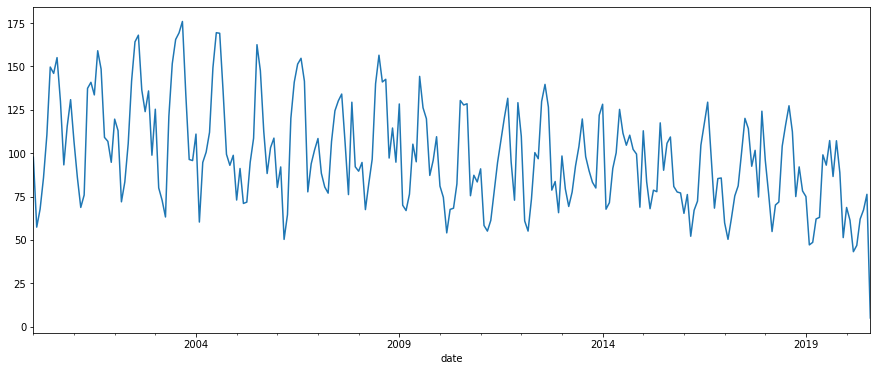

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1539      0.101      1.521      0.128      -0.044       0.352
ma.L1         -0.8840      0.051    -17.187      0.000      -0.985      -0.783
ma.S.L12      -0.8098      0.057    -14.319      0.000      -0.921      -0.699
sigma2       291.9245     19.198     15.206      0.000     254.298     329.551


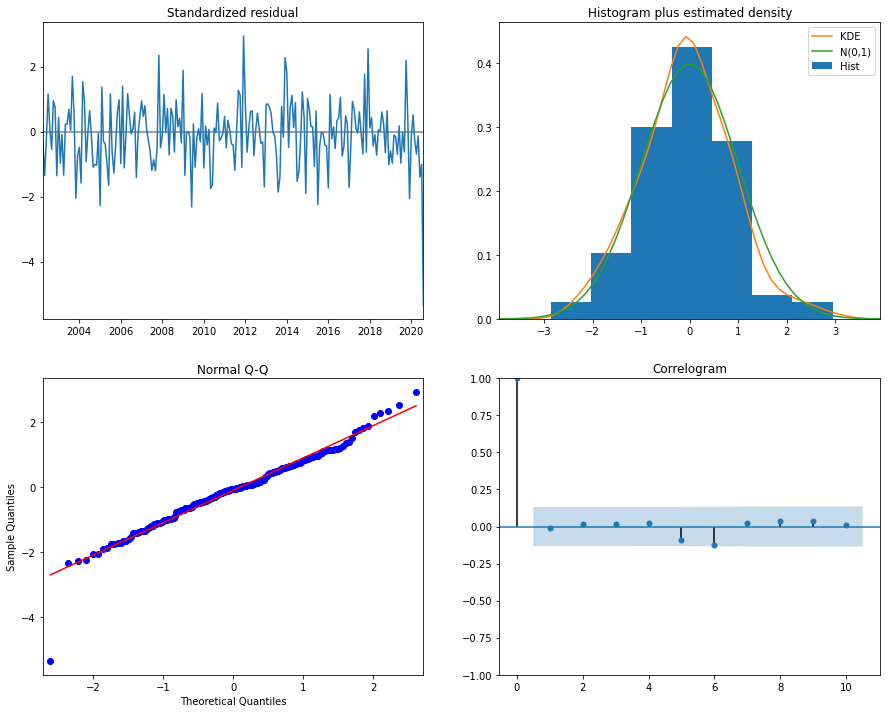

          Date  actual_value
108 2009-01-01    128.322581
109 2009-02-01     69.964286
110 2009-03-01     66.903226
111 2009-04-01     76.366667
112 2009-05-01    105.161290
..         ...           ...
243 2020-04-01     46.800000
244 2020-05-01     62.000000
245 2020-06-01     67.300000
246 2020-07-01     76.258065
247 2020-08-01      5.000000

[140 rows x 2 columns]
The root Mean Squared Error of our forecasts is 25.56


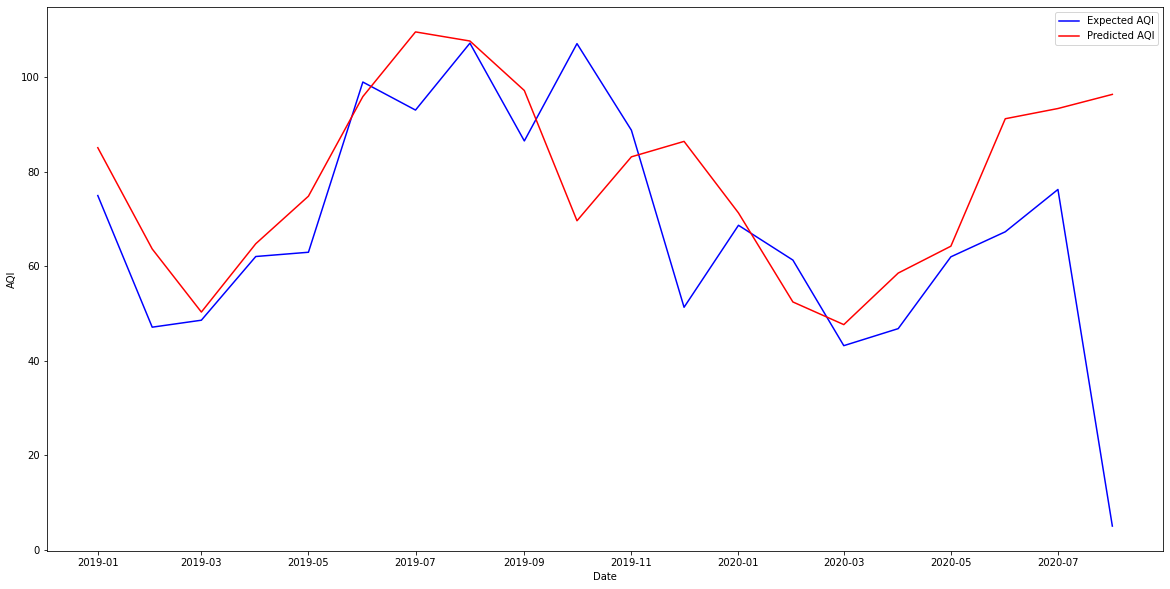

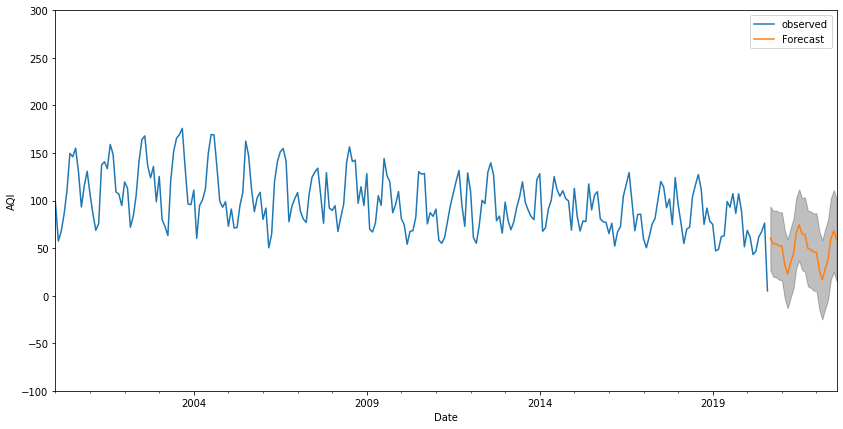

In [74]:
def full_run():
  y_up = forecast_aqi(y)
  small,val1,val2 = best_pdq(y_up)
  results = model_summary(y_up,val1,val2)
  prediction = pred(results, y_up)
full_run()